## Imports & utility functions

In [1]:
from collections import defaultdict
from typing import List, Tuple

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np


In [2]:
def inverse_2x2(x: np.ndarray) -> np.ndarray:
    assert x.shape == (2, 2)
    det = 1 / (x[0, 0] * x[1, 1] - x[0, 1] * x[1, 0])
    new_mat = np.array([
        [x[1, 1], -x[0, 1]],
        [-x[1, 0], x[0, 0]],
    ])
    return det * new_mat

## Main functions definition

In [3]:
def f(x: np.ndarray) -> float:
    return 2 * x[0] ** 2 - 1.05 * x[0]**4 + x[0]**6 / 6 + x[0] * x[1] + x[1] ** 2


def df_dx(x: np.ndarray) -> float:
    return 4 * x[0] - 4 * 1.05 * x[0]**3 + x[0]**5 + x[1]


def df_dy(x: np.ndarray) -> float:
    return x[0] + 2 * x[1]


def grad_f(x: np.ndarray) -> np.ndarray:
    return np.array([df_dx(x), df_dy(x)], dtype=np.float32)


def ddf_dxx(x: np.ndarray) -> float:
    return 4 - 3 * 4 * 1.05 * x[0]**2 + 5 * x[0]**4


def ddf_dxy(x: np.ndarray) -> float:
    return 1


def ddf_dyy(x: np.ndarray) -> float:
    return 2


def hess_f(x: np.ndarray) -> np.ndarray:
    return np.array([
        [ddf_dxx(x), ddf_dxy(x)],
        [ddf_dxy(x), ddf_dyy(x)]
    ], dtype=np.float32)


## Newton method body

In [4]:
def run_newton(x_0, steps=20) -> List[np.ndarray]:
    path = [x_0,]
    x_cur = x_0
    for _i in range(steps):
        x_next = x_cur - grad_f(x_cur) @ inverse_2x2(hess_f(x_cur))
        path.append(x_next)
        x_cur = x_next

    return path

## Experiment

In [5]:
xs = np.linspace(-5, 5, 101)
ys = np.linspace(-5, 5, 101)

start2term = dict()
term2start = defaultdict(list)

for x0 in xs:
    for y0 in ys:
        path = run_newton(np.array([x0, y0]))

        terminal_point = tuple(path[-1].round(5))
        
        start2term[(x0, y0)] = terminal_point
        term2start[terminal_point].append((x0, y0))


In [6]:
print(len(term2start))
print(term2start.keys())

5
dict_keys([(-1.74755, 0.87378), (-1.07054, 0.53527), (1.07054, -0.53527), (0.0, 0.0), (1.74755, -0.87378)])


5 convergence points have been found, you can see the points above.
Let's plot the function itself.

### Function plot
The values are logarithmic in the heamap.

/tmp/ipykernel_4469/2697814897.py:8: RuntimeWarning: divide by zero encountered in log
  contour = plt.contourf(xs, ys, np.log(f_values), 40)


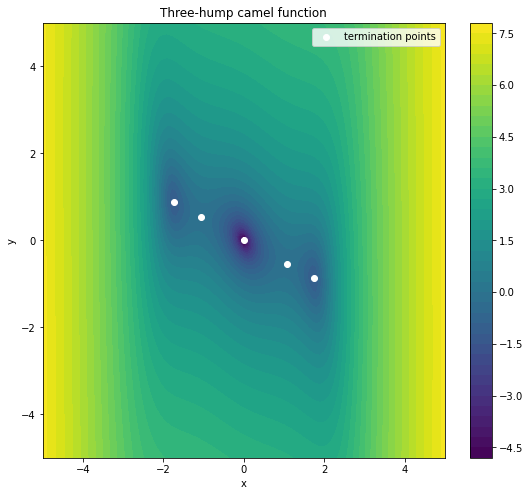

In [7]:
f_values = np.array([
    f(np.array([x, y]))
    for y in xs
    for x in ys
]).reshape(101, 101)

fig = plt.figure(figsize=(9, 8))
contour = plt.contourf(xs, ys, np.log(f_values), 40)
cbar = fig.colorbar(contour)

terms_x = [k[0] for k in term2start.keys()]
terms_y = [k[1] for k in term2start.keys()]
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(terms_x, terms_y, color='white', label='termination points')
plt.legend()
plt.title('Three-hump camel function')
plt.show()

Points 1, 3 and 5 (from left to right) are seem to be real local minimums. The two other points probably occur due to the fact that the gradient is equal to the both local minimums on the left and on the right.

### Termination points mapping

Let's plot where starting points lead to. The color for a position means the correspoing finishing point.

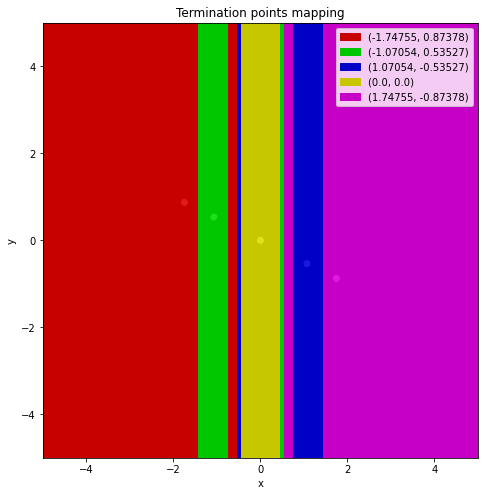

In [8]:
COLORS = np.array([[200, 0, 0], [0, 200, 0], [0, 0, 200], [200, 200, 0], [200, 0, 200]], dtype=np.float32) / 256
term2color = dict(zip(term2start.keys(), COLORS))

start2color = np.array([
    term2color[start2term[(x, y)]]
    for y in xs
    for x in ys
]).reshape(101, 101, 3)

fig = plt.figure(figsize=(9, 8))
plt.imshow(start2color, extent=(xs.min(), xs.max(), ys.min(), ys.max()))

plt.xlabel('x')
plt.ylabel('y')
plt.scatter(terms_x, terms_y, c=COLORS+0.1)

patches = [
    mpl.patches.Patch(color=color, label=f'{term}')
    for term, color in term2color.items()
]
gree_patch = mpl.patches.Patch(color='green', label='The green data')
plt.legend(handles=patches)

plt.title('Termination points mapping', )
plt.show()

While the red zone at the left, the yellow zone in the middle and the purple zone at the right are seem to be reasonable, other zones can be confusing. There are three questions may arise:
1. Why the plot is symmetrical by $x$?
2. Why are there small zones of red, blue, green and purple somewhere between the large zones?
3. What are green and blue zones, as is doesn't seems to be local optimums there in the plot? 

Let's try to speculate on how it can be explained:
1. Both the function and derivatives are hugely dependent on $x$ due to the powers. Probably the plot isn't actually symmetic but at our scale it seems to be so.

/tmp/ipykernel_4469/1514717402.py:6: RuntimeWarning: divide by zero encountered in log
  contour = ax1.contourf(xs, ys, np.log(f_values), 100)


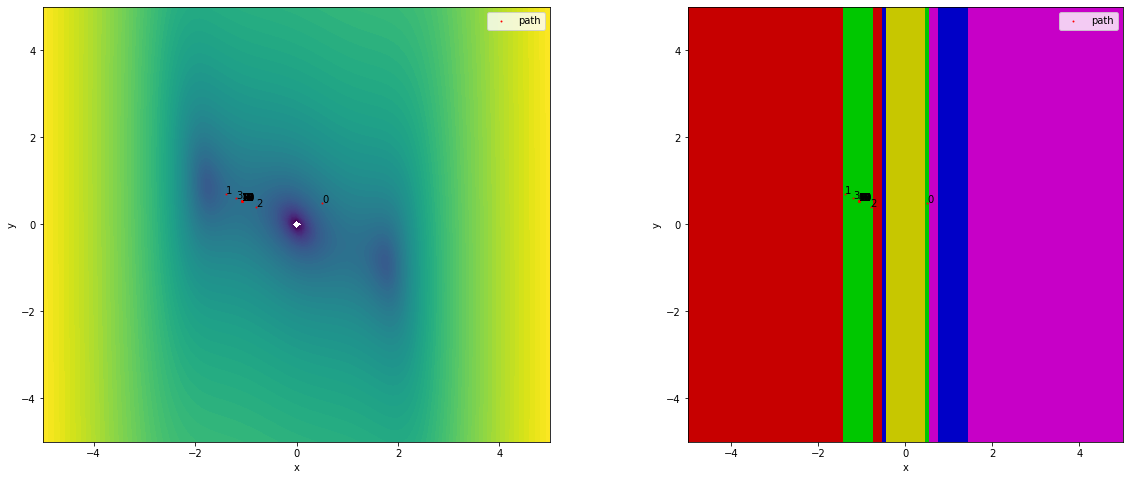

In [9]:
def build_path(starting_point: Tuple[float, float]) -> None:
    path = run_newton(np.array(starting_point, dtype=np.float32))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    contour = ax1.contourf(xs, ys, np.log(f_values), 100)

    terms_x = [k[0] for k in term2start.keys()]
    terms_y = [k[1] for k in term2start.keys()]
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')

    ax1.scatter([p[0] for p in path], [p[1] for p in path], s=0.9, color='red', label='path')
    ax2.scatter([p[0] for p in path], [p[1] for p in path], s=0.9, color='red', label='path')


    plt.imshow(start2color, extent=(xs.min(), xs.max(), ys.min(), ys.max()))

    for i, (x, y) in enumerate(path):
        ax1.annotate(str(i), (x, y))
        ax2.annotate(str(i), (x, y))

    ax1.legend()
    ax2.legend()

    plt.show()
    
build_path((0.5, 0.5))

\**the artifact in the center of the first plot is due to the logaritm calculation close to the zero* 

2. As we can see here, the point is out of the convergence zone for middle point. In the first step the Newton gradient is too high, so the point passes through the middle local optimum on the first step. Then it simply never comes back and finishes at $(-1.07054, 0.53527)$.

3. The function plot shows that $(-1.07054, 0.53527)$, $(1.07054, -0.53527)$ are probably the saddle points. Why Newton's steps are tend to choose it as the destination point? Let's calculate some of the values:

In [10]:
# Let's get more precision
x_saddle = run_newton(np.array([-1.07054, 0.53527]), steps=20)[-1]

print('Saddle point:')
print(x_saddle)

print('Gradient vector')
print(grad_f(x_saddle))

print('Hessian matrix:')
print(hess_f(x_saddle))

print('Inverted Hessian matrix:')
print(inverse_2x2(hess_f(x_saddle)))

print("Newton's method step:")
print(grad_f(x_saddle) @ inverse_2x2(hess_f(x_saddle)))

Saddle point:
[-1.07054229  0.53527115]
Gradient vector
[1.110223e-16 0.000000e+00]
Hessian matrix:
[[-3.8730893  1.       ]
 [ 1.         2.       ]]
Inverted Hessian matrix:
[[-0.2286713   0.11433565]
 [ 0.11433565  0.44283217]]
Newton's method step:
[-2.5387614e-17  1.2693807e-17]


So the problem here is that Newton method converges to points where the gradient is zero. This is the case here, the gradient is really close to zero, that's why some point converge to this area.